用于基于模型预测

本文件预测一个末端轨迹服从XoY平面内一封闭圆周的运动序列

7.5cm, 1cm

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import torch
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib ipympl

In [2]:
input_size = 3
hidden_size = 32
output_size = 3
num_epochs = 200
num_layers = 2
learning_rate = 0.001 
dropout = 0.2

In [3]:
import os
os.getcwd() #得到当前工作目录

'g:\\我的云端硬盘\\Soft robotic arm\\code&data\\code\\trajectory_tracking'

In [4]:
TRAINING_SET = '../../training_sets/round0.csv' # training set
training_set = 'round0'
MODEL_PATH = '../model_training/models'
TEST_FILE  = '../../test_sets/No3x4.csv' # testing set
FIGURE_PATH = './figures'
TARGET_CTRL_PRES = './control_presets'

In [5]:
# reshape the data into a 2D array
def reshape_data(input):
    data = []
    for seq in input:
        for row in seq:
            data.append(row)
    return np.array(data)

# reshape the data back to the original format
def reshape_back(input, format):
    data = []
    index = 0
    for seq in format:
        seq_data = []
        for _ in seq:
            seq_data.append(input[index])
            index += 1
        data.append(seq_data)
    return data

In [6]:
# create an empty list to hold the sequences
training_data = []

# read the CSV file and split it into sequences
with open(TRAINING_SET, newline='') as f:
    reader = csv.reader(f)
    for row in reader:
        if row[0] == '':  # empty row indicates end of sequence
            continue
        else:
            # convert the row to a list of floats and append to the sequence
            row_float = [float(x) for x in row]
            training_data.append(row_float)

print('training_position size:', len(training_data), 'x', len(training_data[0]))

training_position size: 182 x 6


In [7]:
# Extract the relevant coordinates from the training_data array
x_coords = [x[3] for x in training_data]
y_coords = [-x[4] for x in training_data]
z_coords = [x[5] for x in training_data]

# Combine the coordinates into a single array
points = np.column_stack((x_coords, y_coords, z_coords))

# Calculate the Euclidean distance between each pair of adjacent points
distances = np.linalg.norm(points[:-1] - points[1:], axis=1)

# Calculate the mean distance between adjacent points
mean_distance = distances.mean()

print(f"The mean distance between adjacent points is {mean_distance:.2f}")

The mean distance between adjacent points is 7.42


In [8]:
# # create an empty list to hold the sequences
# training_data = []
# a = 1

# # read the CSV file and split it into sequences
# with open(TRAINING_SET, newline='') as f:
#     reader = csv.reader(f)
#     for row in reader:
#         if row[0] == '':  # empty row indicates end of sequence
#             a = 1
#             continue
#         else:
#             # load the first point of the sequence
#             if(a == 1):
#                 # convert the row to a list of floats and append to the sequence
#                 row_float = [float(x) for x in row]
#                 training_data.append(row_float)
#                 a = 0

# print('training_position size:', len(training_data), 'x', len(training_data[0]))

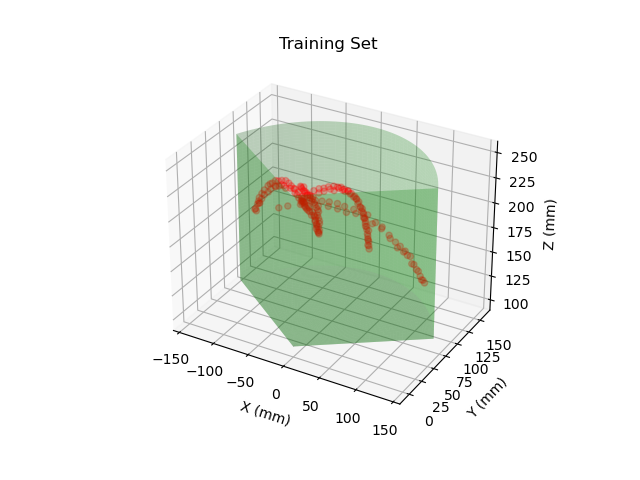

In [9]:
# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter([x[3] for x in training_data], [-x[4] for x in training_data], 
                     [x[5] for x in training_data], alpha=0.25, c='r', marker='o')

# Create a 1/3 cylinder
radius = 160
height_z = 150
center_x = 0
center_y = 0
center_z = 100

# Circle parameters
circle_radius = radius
circle_angle = np.radians(120) # 120 degrees in radians
circle_start_angle = np.radians(240) # Start angle of the circle, 240 degrees in radians

# Plot the cylinder
z = np.linspace(center_z, center_z+height_z, 50)
theta = np.linspace(7*np.pi/6, 11*np.pi/6, 50)
theta_grid, z_grid=np.meshgrid(theta, z)
x_grid = radius*np.cos(theta_grid) + center_x
y_grid = radius*np.sin(theta_grid) + center_y
ax.plot_surface(x_grid, -y_grid, z_grid, alpha=0.25,color='green')

# Plot the circle
theta = np.linspace(0, np.pi/2, 100)
phi = np.linspace(7*np.pi/6, 11*np.pi/6, 100)
theta, phi = np.meshgrid(theta, phi)
x = radius*np.sin(theta)*np.cos(phi)
y = radius*np.sin(theta)*np.sin(phi)
z = np.zeros_like(x)+center_z
ax.plot_surface(x, -y, z, alpha=0.25,color='green')

# Plot the rectangle
# Define four points as vertices of the rectangle in 3D space
point1 = [0, 0, 100]
point2 = [radius*np.cos(np.pi/6), radius*np.sin(np.pi/6), 100]
point3 = [radius*np.cos(np.pi/6), radius*np.sin(np.pi/6), 100+height_z]
point4 = [0, 0, 100+height_z]
x = [point1[0], point2[0], point3[0], point4[0]]
y = [point1[1], point2[1], point3[1], point4[1]]
z = [point1[2], point2[2], point3[2], point4[2]]

# Draw square plane1
verts = [list(zip(x,y,z))]
ax.add_collection3d(Poly3DCollection(verts, alpha=.25, facecolor='green'))

# Draw square plane2
x = [-point1[0], -point2[0], -point3[0], -point4[0]]

verts = [list(zip(x,y,z))]
ax.add_collection3d(Poly3DCollection(verts, alpha=.25, facecolor='green'))

# Add labels to the plot
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_title('Training Set')

# Normalize the axes to achieve equal scaling
ax.set_box_aspect([4,3,3])

# Show the plot
plt.show()

In [241]:
# # Triangle
# track_name = 'triangle_lower'
# # track_name = 'triangle_lower_reverse'

# # Define known points
# # Middle
# # point0 = np.array([7, -12, 235])  # Zero point
# # point1 = np.array([75, -70, 200])  # Second known point
# # point2 = np.array([-75, -70, 200])  # Third known point

# # Lower
# point0 = np.array([7, -12, 235])  # Zero point
# point1 = np.array([80, -100, 160])  # Second known point
# point2 = np.array([-80, -100, 160])  # Third known point

# # Define the number of points to generate along the line (including endpoints)
# num_points = 17

# # Generate points along the line
# points1 = np.linspace(point0, point1, num_points, endpoint=False)
# points2 = np.linspace(point1, point2, num_points, endpoint=False)
# points3 = np.linspace(point2, point0, num_points)

# # Reverse
# # points1 = np.linspace(point0, point2, num_points, endpoint=False)
# # points2 = np.linspace(point2, point1, num_points, endpoint=False)
# # points3 = np.linspace(point1, point0, num_points)

# # Conbine the points
# points = np.concatenate((points1, points2, points3), axis=0)

# # Plot the points
# ax.scatter(points[:,0], -points[:,1], points[:,2], c='b', marker='o')
# plt.show()

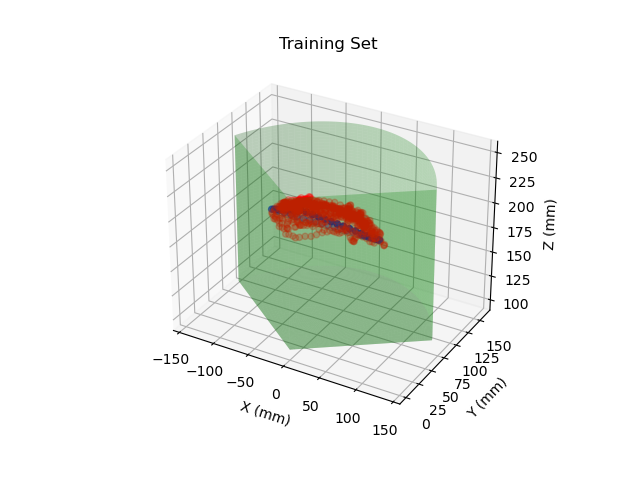

In [242]:
# Quadrilateral
track_name = 'quadrilateral_lower'
track_name = 'quadrilateral_lower_reverse'

# Define known points
# Middle
# point0 = np.array([7, -12, 235])  # Zero point
# point1 = np.array([75, -60, 210])  # Second known point
# point2 = np.array([0, -120, 185])  # Third known point
# point3 = np.array([-75, -60, 210])  # Fourth known point

# Lower
point0 = np.array([7, -12, 235])  # Zero point
point1 = np.array([75, -65, 195])  # Second known point
point2 = np.array([0, -130, 155])  # Third known point
point3 = np.array([-75, -65, 195])  # Fourth known point

# Define the number of points to generate along the line (including endpoints)
num_points = 14

# Generate points along the line
points1 = np.linspace(point0, point1, num_points, endpoint=False)
points2 = np.linspace(point1, point2, num_points, endpoint=False)
points3 = np.linspace(point2, point3, num_points, endpoint=False)
points4 = np.linspace(point3, point0, num_points)

# Reverse
points1 = np.linspace(point0, point3, num_points, endpoint=False)
points2 = np.linspace(point3, point2, num_points, endpoint=False)
points3 = np.linspace(point2, point1, num_points, endpoint=False)
points4 = np.linspace(point1, point0, num_points)

# Conbine the points
points = np.concatenate((points1, points2, points3, points4), axis=0)

# Plot the points
ax.scatter(points[:,0], -points[:,1], points[:,2], c='b', marker='o')
plt.show()

In [243]:
# # pentagon
# track_name = 'pentagon'
# # track_name = 'pentagon_reverse'

# # Define known points
# # Lower
# point0 = np.array([7, -12, 240])  # Zero point
# point1 = np.array([80, -60, 205])  # Second known point
# point2 = np.array([45, -120, 170])  # Third known point
# point3 = np.array([-45, -120, 170])  # Fourth known point
# point4 = np.array([-80, -60, 205])  # Fifth known point

# # Define the number of points to generate along the line (including endpoints)
# num_points = 12

# # Generate points along the line
# points1 = np.linspace(point0, point1, num_points, endpoint=False)
# points2 = np.linspace(point1, point2, num_points, endpoint=False)
# points3 = np.linspace(point2, point3, num_points, endpoint=False)
# points4 = np.linspace(point3, point4, num_points, endpoint=False)
# points5 = np.linspace(point4, point0, num_points)

# # Reverse
# # points1 = np.linspace(point0, point4, num_points, endpoint=False)
# # points2 = np.linspace(point4, point3, num_points, endpoint=False)
# # points3 = np.linspace(point3, point2, num_points, endpoint=False)
# # points4 = np.linspace(point2, point1, num_points, endpoint=False)
# # points5 = np.linspace(point1, point0, num_points)

# # Conbine the points
# points = np.concatenate((points1, points2, points3, points4, points5), axis=0)

# # Plot the points
# ax.scatter(points[:,0], -points[:,1], points[:,2], c='b', marker='o')
# plt.show()

In [244]:
# Calculate the Euclidean distance between each pair of adjacent points
distances = np.linalg.norm(points[:-1] - points[1:], axis=1)

# Calculate the mean distance between adjacent points
mean_distance = distances.mean()

print(f"The mean distance between adjacent points is {mean_distance:.2f}")

The mean distance between adjacent points is 7.54


In [245]:
# normalize the data between -0.5 and 0.5
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
scaled_data = scaler.fit_transform(training_data)

In [246]:
# normalize the target data
targets = np.zeros((len(points), 6))
targets[:,3:] = points
normalized_targets = scaler.transform(targets)
print('normalized_targets size:', len(normalized_targets), 'x', len(normalized_targets[0]))

normalized_targets size: 56 x 6


In [247]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout_layer = torch.nn.Dropout(self.dropout)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout_layer(out)
        out = self.fc(out)
        return out

In [248]:
# load the data into a torch tensor
target = torch.tensor(normalized_targets, dtype=torch.float32)

# Load the trained model
model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout)
model.load_state_dict(torch.load(MODEL_PATH+'/LSTM_'+ str(training_set)+'_'+str(learning_rate)+'_'+
                   str(hidden_size)+'_'+str(num_epochs)+'_'+str(num_layers)+ '_' +str(dropout)+'.pth'))

# Put the model in evaluation mode
model.eval()

LSTMModel(
  (lstm): LSTM(3, 32, num_layers=2, batch_first=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)

In [249]:
# extract the input sequences
input_data = target[:, 3:]
input_data = input_data.unsqueeze(0)

# Forward pass to get prediction
with torch.no_grad():
    prediction = model(input_data)

print('prediction size:', len(prediction), 'x', len(prediction[0]), 'x', len(prediction[0][0]))

prediction size: 1 x 56 x 3


In [250]:
# Reshape the prediction into a 2D array
normalized_targets[:, :3] = prediction.reshape(-1, 3)

# Denormalize the data
final_prediction = scaler.inverse_transform(normalized_targets)

print('denormalized_targets size:', len(final_prediction), 'x', len(final_prediction[0]))

denormalized_targets size: 56 x 6


In [251]:
# filename = TARGET_CTRL_PRES + '/' + 'LSTM_' + str(track_name) + '_' + str(training_set)+'_'+str(learning_rate)+'_'+str(hidden_size)+'_'+str(num_epochs)+'_'+str(num_layers)+'_' +str(dropout)+'.csv'
# with open(filename,'w',newline='') as target:
#     writer = csv.writer(target)
#     for i in range(len(final_prediction)):
#         writer.writerow([final_prediction[i,0],final_prediction[i,1],final_prediction[i,2],
#                          final_prediction[i,3],final_prediction[i,4],final_prediction[i,5]]) 

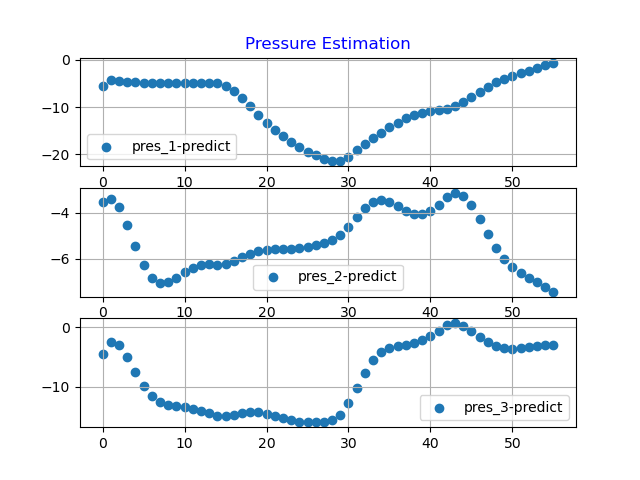

In [252]:
t = np.arange(len(final_prediction))
fig = plt.figure()
plt.subplot(3,1,1)
plt.title('Pressure Estimation',color='blue')
plt.scatter(t,final_prediction[:,0],label='pres_1-predict')
plt.legend()
plt.grid()
plt.subplot(3,1,2)
plt.scatter(t,final_prediction[:,1],label='pres_2-predict')
plt.legend()
plt.grid()
plt.subplot(3,1,3)
plt.scatter(t,final_prediction[:,2],label='pres_3-predict')
plt.legend()
plt.grid()
plt.show()